# Testing DEMV on _The Trump Effect_ dataset

**Protected group:** `GENDER=0 & RELIGION=0`

In [4]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

import seaborn as sns

from fairlearn.reductions import ZeroOneLoss, ExponentiatedGradient, BoundedGroupLoss

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [5]:
def make_data():
    data = pd.read_csv('data2/data_e28.csv - data_e28.csv.csv', index_col='[meta] uuid')
    data.rename(columns = lambda c: c[c.find("]")+1:].replace("_", " ").upper().strip(), inplace=True)
    
    voted = data['VOTED PARTY LAST ELECTION DE'][data['COUNTRY CODE'] == 'DE']\
    .append(data['VOTED PARTY LAST ELECTION IT'][data['COUNTRY CODE'] == 'IT'])\
    .append(data['VOTED PARTY LAST ELECTION FR'][data['COUNTRY CODE'] == 'FR'])\
    .append(data['VOTED PARTY LAST ELECTION GB'][data['COUNTRY CODE'] == 'GB'])\
    .append(data['VOTED PARTY LAST ELECTION ES'][data['COUNTRY CODE'] == 'ES'])\
    .append(data['VOTED PARTY LAST ELECTION PL'][data['COUNTRY CODE'] == 'PL'])

    rankingParty = data['RANKING PARTY DE'][data['COUNTRY CODE'] == 'DE']\
    .append(data['RANKING PARTY IT'][data['COUNTRY CODE'] == 'IT'])\
    .append(data['RANKING PARTY FR'][data['COUNTRY CODE'] == 'FR'])\
    .append(data['RANKING PARTY GB'][data['COUNTRY CODE'] == 'GB'])\
    .append(data['RANKING PARTY ES'][data['COUNTRY CODE'] == 'ES'])\
    .append(data['RANKING PARTY PL'][data['COUNTRY CODE'] == 'PL'])

    voteNextElection = pd.concat([data['VOTE NEXTELECTION DE'][data['COUNTRY CODE'] == 'DE'],
                                    data['VOTE NEXTELECTION IT'][data['COUNTRY CODE'] == 'IT'],
                                    data['VOTE NEXTELECTION FR'][data['COUNTRY CODE'] == 'FR'],
                                    data['VOTE NEXTELECTION GB'][data['COUNTRY CODE'] == 'GB'],
                                    data['VOTE NEXTELECTION ES'][data['COUNTRY CODE'] == 'ES'],
                                    data['VOTE NEXTELECTION PL'][data['COUNTRY CODE'] == 'PL']], verify_integrity=True)

    data['VOTED PARTY LAST ELECTION'] = voted
    data['RANKING PARTY'] = rankingParty
    data['VOTE NEXT ELECTION'] = voteNextElection

    data.drop(['VOTED PARTY LAST ELECTION DE', 'VOTED PARTY LAST ELECTION IT', 'VOTED PARTY LAST ELECTION FR',
               'VOTED PARTY LAST ELECTION GB', 'VOTED PARTY LAST ELECTION ES', 'VOTED PARTY LAST ELECTION PL',
               'RANKING PARTY DE', 'RANKING PARTY IT', 'RANKING PARTY FR', 'RANKING PARTY GB', 'RANKING PARTY ES', 
               'RANKING PARTY PL', 'VOTE NEXTELECTION DE', 'VOTE NEXTELECTION IT', 'VOTE NEXTELECTION FR', 'VOTE NEXTELECTION GB',
               'VOTE NEXTELECTION ES', 'VOTE NEXTELECTION PL'], axis=1, inplace=True)

    data.drop('VOTE REFERENDUM', axis = 1, inplace=True)

    data.drop('EMPLOYMENT STATUS IN EDUCATION', axis=1, inplace=True)

    data.drop('ORIGIN', axis=1, inplace=True)

    data['MEMBER ORGANIZATION'].fillna('Not member', inplace=True)
    data.loc[data['MEMBER ORGANIZATION']=='Not member', 'ORGANIZATION ACTIVITIES TIMEPERWEEK'] = 'Not member'

    data.drop(data.loc[data['HOUSEHOLD SIZE'].isnull()].index, inplace=True)

    data.drop(data.loc[data['SOCIAL NETWORKS REGULARLY USED'].isnull()].index, inplace=True)

    nullcols = data.isna().any()[data.isna().any()==True].index
    data.drop(nullcols, axis=1, inplace=True)

    data.drop('WEIGHT', axis=1, inplace=True)
    data.loc[data['GENDER']=='male', 'GENDER'] = 1
    data.loc[data['GENDER']!=1, 'GENDER'] = 0
    data['GENDER'] = data['GENDER'].astype(int)
    data.loc[data['RELIGION'] == 'Roman Catholic', 'RELIGION'] = 1
    data.loc[data['RELIGION'] != 1, 'RELIGION'] = 0
    data['RELIGION'] = data['RELIGION'].astype(int)
    enc = LabelEncoder()
    data['POLITICAL VIEW'] = enc.fit_transform(data['POLITICAL VIEW'].values)
    data.rename(columns= lambda c: c.replace(" ", "_"), inplace=True)
    for c in data.columns:
        if len(data[c].unique())>6:
            data.drop(c, axis=1, inplace=True)
    return data

In [6]:
data = make_data()

In [7]:
data = pd.get_dummies(data)

In [8]:
data.shape

(7951, 204)

In [9]:
data[(data['GENDER']==0)&(data['RELIGION']==0)].shape

(2442, 204)

In [10]:
label = 'POLITICAL_VIEW'
protected_group = {'GENDER': 0, 'RELIGION': 0}
sensitive_variables=['GENDER', 'RELIGION']
positive_label = 3

In [11]:
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "classifier",
            LogisticRegression(),
        ),
    ]
)


## Bias dataset

### Logistic Regression

In [12]:
model, lr_metrics, pred = cross_val2(pipeline, data, label, protected_group, sensitive_features=sensitive_variables, positive_label=positive_label)
print_metrics(lr_metrics)

Statistical parity:  -0.011  +-  0.009
Disparate impact:  0.718  +-  0.211
Zero one loss:  0.067  +-  0.041
F1 score:  0.387  +-  0.012
Accuracy score:  0.396  +-  0.014


## DEMV application

In [13]:
demv = DEMV(round_level=1)
demv_data = data.copy()

### Logistic regression

In [14]:
model, metrics_demv = cross_val(pipeline, demv_data, label, protected_group, sensitive_features=sensitive_variables, debiaser=demv, positive_label=positive_label)
print_metrics(metrics_demv)

Statistical parity:  -0.007  +-  0.013
Disparate impact:  0.72  +-  0.219
Zero one loss:  0.068  +-  0.046
F1 score:  0.381  +-  0.012
Accuracy score:  0.391  +-  0.013


##  Blackbox Postprocessing

In [15]:
sensitive_features = ['combined']
unpriv_group = {'combined': 1}

In [17]:
data.loc[:,"combined"] = 0
data.loc[(data['GENDER'] == 0) & (data["RELIGION"] == 0),"combined"] = 1
#Now pred has the actual values on column "y_true" and predicted values on column "contr_use"

pred.loc[:,"combined"] = 0
pred.loc[(pred['GENDER'] == 0) & (pred["RELIGION"] == 0),"combined"] = 1

y_pred = pred[label].values
y_true = pred['y_true'].values

import tools
stats = tools.clf_metrics(y_true, y_pred)
stats

,tp,fp,tn,fn,sens,spec,ppv,npv,j,f1,mcc,brier,auc,ap,true_prev,pred_prev,prev_diff,rel_prev_diff
0,830.0,1200.0,4870.0,1052.0,0.3964,0.7898,0.3854,0.8108,0.1862,0.3868,0.1904,0.2832,0.0,0.0,1882.0,2029.0,147.0,0.0


In [20]:
%load_ext autoreload
%autoreload 2

In [22]:
blackboxmetrics = blackboxCVmetrics( data, label, y_true, unpriv_group, pred )

___:____
[[[0.48427673 0.35220126 0.         0.02515723 0.10691824 0.03144654]
  [0.35028249 0.46892655 0.         0.03389831 0.06779661 0.07909605]
  [0.10526316 0.36842105 0.10526316 0.10526316 0.26315789 0.05263158]
  [0.05263158 0.42105263 0.15789474 0.21052632 0.05263158 0.10526316]
  [0.36082474 0.25773196 0.03092784 0.02061856 0.26804124 0.06185567]
  [0.15189873 0.29113924 0.01265823 0.06329114 0.10126582 0.37974684]]

 [[0.5505618  0.24719101 0.         0.03370787 0.15730337 0.01123596]
  [0.38888889 0.37037037 0.         0.         0.12962963 0.11111111]
  [0.11111111 0.38888889 0.16666667 0.         0.33333333 0.        ]
  [0.16666667 0.16666667 0.         0.16666667 0.33333333 0.16666667]
  [0.42622951 0.21311475 0.03278689 0.03278689 0.26229508 0.03278689]
  [0.16666667 0.44444444 0.05555556 0.05555556 0.11111111 0.16666667]]]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2864  0.4843
1  0.3190  0.4689
2  0.0132  0.1053
3  0.0358  0.2105
4  0.0949  0.2680
5  

## DEMV Evaluation

In [23]:
demv.get_iters()

64

In [24]:
metrics = eval_demv(15, 64, data.copy(), pipeline, label, protected_group, sensitive_variables, positive_label=positive_label)

In [25]:
df = prepareplots(metrics,'trump')

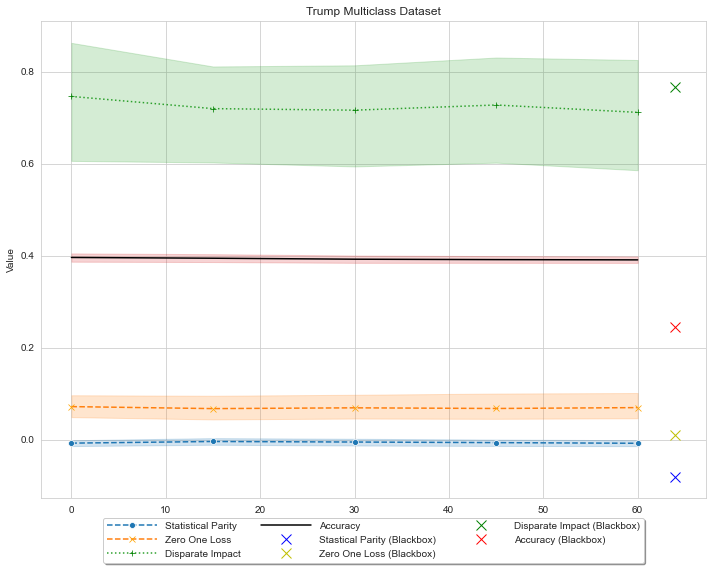

In [26]:
points = preparepoints(blackboxmetrics, demv.get_iters())
plot_metrics_curves(df, points, 'Trump Multiclass Dataset')

In [27]:
unprivpergentage(data,protected_group, demv.get_iters())

Dataset size: 7951
Unprivileged group size: 2442
Percentage of unprivileged group: 30.71311784681172
Number of iterations: 64
